In [1]:
import pickle
from hdf5storage import loadmat
import numpy as np

In [2]:
n_items = 60
n_selected = 6
n_obj = 3
kn = loadmat(f'/data/knapsack/runB/kn_2_3_allneg_{n_items}_{n_selected}_{n_obj}.mat')
n_con = kn['n_con'] 
capacity = kn['capacity']
rng = np.random.RandomState(1123)
pop_size = 500_000
run = 2

In [22]:
def best_ratio_item(items, obj_to_max):
    ratios = items[:, obj_to_max] / items[:, -1]
    sort_indices = np.argsort(ratios)
    best_item_index = sort_indices[-1]
    return best_item_index

def create_heuristic_samples(pop_size, items,n_items, n_selected, n_obj, n_con, capacity, rng):
    pop_count = 0
    population = np.zeros((pop_size, n_selected), dtype=np.int32)
    objectives = np.zeros((pop_size, n_obj))
    # seen_obj = set()  
    while pop_count < pop_size:
        remain_ind = np.arange(n_items)
        knapsack_indices = np.zeros(n_selected, dtype=int)    
        knapsack = np.zeros((n_selected, (n_obj+n_con)))
        for n in range(0, n_selected):
            current_items = items[remain_ind, :]
            obj_to_max = rng.randint(n_obj) 
            choice_ind = best_ratio_item(current_items, obj_to_max)
            choice_ind_ori = remain_ind[choice_ind]
            knapsack_indices[n] = choice_ind_ori
            knapsack[n, :] = items[choice_ind_ori, :]
            remain_ind = np.delete(remain_ind, choice_ind) 
        
        constraint = np.sum(items[knapsack_indices, -1])
        if constraint <= capacity:
            # obj_vec = np.sum(knapsack[:, :n_obj], axis=0)
            # obj_key = tuple(obj_vec)
            # if obj_key not in seen_obj:
                # seen_obj.add(obj_key)
            population[pop_count, :] = knapsack_indices
            objectives[pop_count, :] = np.sum(knapsack[:, :n_obj], axis=0)
            pop_count += 1
    
    return population, objectives

In [ ]:
items = kn['items'][run]
population, objectives = create_heuristic_samples(pop_size, items,n_items, n_selected, n_obj, n_con, capacity, rng)
objectives_unique = np.unique(objectives, axis=0)

In [5]:
with open(f'results_final/final_2_3_{n_items}_{n_selected}_obj{n_obj}_run{run}.pkl', 'rb') as f:
    results = pickle.load(f)
converged_pf = results['converged_pf_table'][-1]

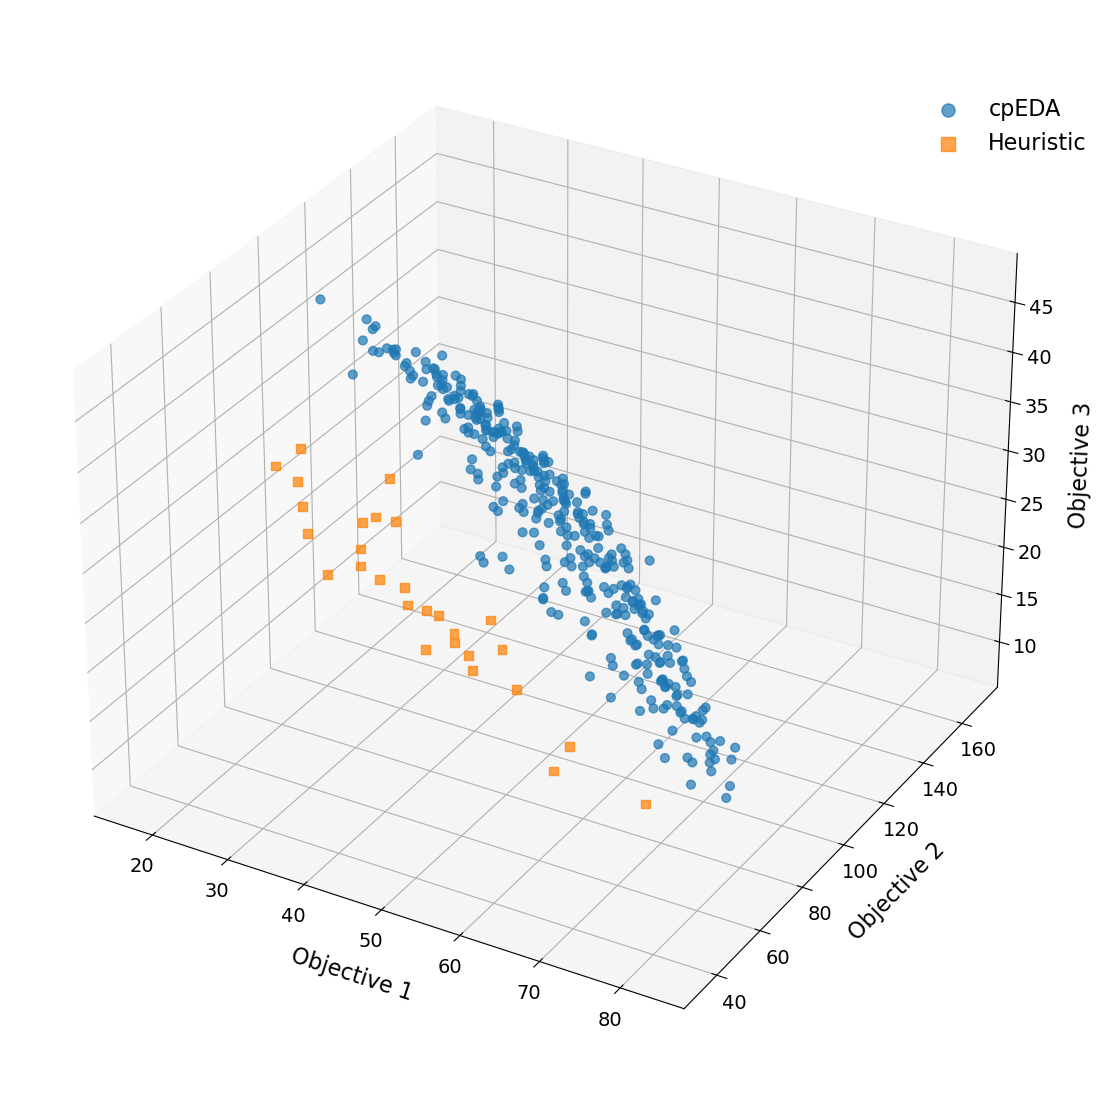

In [ ]:
from matplotlib import pyplot as plt
%matplotlib widget
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

palette = sns.color_palette("Paired")

fig = plt.figure(figsize=(11, 11))
ax = fig.add_subplot(projection='3d')
# ax.xaxis.pane.set_facecolor((1, 1, 1, 1))
# ax.yaxis.pane.set_facecolor((1, 1, 1, 1))
# ax.zaxis.pane.set_facecolor((1, 1, 1, 1))
# ax.grid(False)


ax.scatter(
    converged_pf[:, 0],
    converged_pf[:, 1],
    converged_pf[:, 2],
    color=palette[1],
    marker='o',
    alpha=0.7,
    s=40,
    label='cpEDA'
)

ax.scatter(
    objectives_unique[:, 0],
    objectives_unique[:, 1],
    objectives_unique[:, 2],
    color=palette[7],
    marker='s',
    alpha=0.7,
    s=40,
    label='Heuristic'
)

ax.set_xlabel('Objective 1', fontsize=16, labelpad=12)
ax.set_ylabel('Objective 2', fontsize=16, labelpad=12)
ax.set_zlabel('Objective 3', fontsize=16, labelpad=12)
ax.tick_params(labelsize=14)
    
ax.legend(fontsize=16, frameon=False, loc="upper right",
    bbox_to_anchor=(1.04, 0.95), markerscale=1.5)

# margin = 0.02
# xmin, ymin, zmin = converged_pf.min(axis=0)
# xmax, ymax, zmax = converged_pf.max(axis=0)
# dx = xmax - xmin
# dy = ymax - ymin
# dz = zmax - zmin
# ax.set_xlim(xmin - margin*dx, xmax + margin*dx)
# ax.set_ylim(ymin - margin*dy, ymax + margin*dy)
# ax.set_zlim(zmin - margin*dz, zmax + margin*dz)

plt.tight_layout()
plt.show()
# fig.subplots_adjust(right=1.04)
# fig.savefig(
#     "cpEDA_heuristic_60_6_3_run2.png",
#     dpi=300,
#     bbox_inches="tight"
# )

In [ ]:
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(4.5, 11), sharex=False, sharey=False)

pairs = [
    (0, 1, "Objective 1", "Objective 2"),
    (1, 2, "Objective 2", "Objective 3"),
    (0, 2, "Objective 1", "Objective 3"),
]

for ax, (i, j, xl, yl) in zip(axes, pairs):
    # cpEDA
    ax.scatter(
        converged_pf[:, i], converged_pf[:, j],
        color=palette[1], marker='o', alpha=0.7, s=25, label="cpEDA"
    )
    # Heuristic
    ax.scatter(
        objectives_unique[:, i], objectives_unique[:, j],
        color=palette[7], marker='s', alpha=0.7, s=25, label="Heuristic"
    )

    ax.set_xlabel(xl, fontsize=14, labelpad=8)
    ax.set_ylabel(yl, fontsize=14, labelpad=8)
    ax.tick_params(labelsize=12)

    # Make it look like a scientific figure
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

# One legend for the whole figure (top, close to axes)
# handles, labels = axes[0].get_legend_handles_labels()
# fig.legend(
#     handles, labels,
#     loc="right",
#     bbox_to_anchor=(0.5, 0.995),
#     ncol=2,
#     frameon=False,
#     fontsize=14,
#     markerscale=1.3,
#     handlelength=1.6,
#     columnspacing=1.5
# )

# Tight layout with room for the global legend
fig.tight_layout(rect=(0, 0, 1, 0.97))

fig.savefig(
    "cpEDA_heuristic_2D_column.png",
    dpi=300,
    bbox_inches="tight",
    pad_inches=0.02
)
plt.show()

In [65]:
dists = results['first_sample_probabilities_list_table'][10]
items = results['first_sample_choices_list_table'][10]

In [63]:
items[1]

18

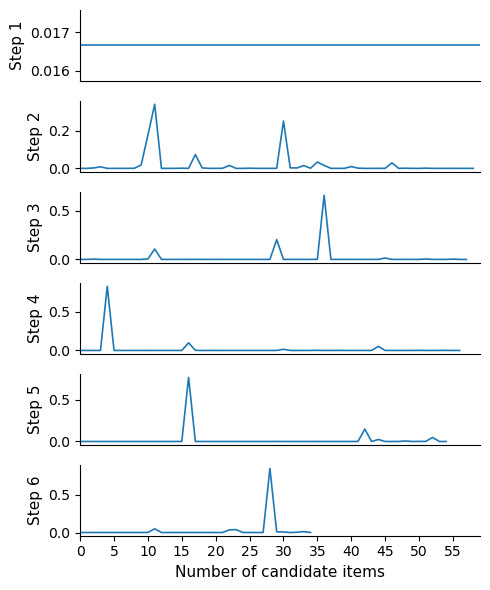

In [84]:
from turtle import color
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FormatStrFormatter

base_color = sns.color_palette("Paired")[1]
# bright_colors = sns.light_palette(
#     base_color,
#     n_colors=5,
# )[2:]
# dark_colors = sns.dark_palette(
#     base_color,
#     n_colors=3,
#     reverse=True
# )[1:]   
# colors = bright_colors + [base_color] + dark_colors
# cmap = sns.color_palette("mako", as_cmap=True)
# colors = [cmap(x) for x in np.linspace(0.15, 0.9, 6)]

max_len = max(len(p) for p in dists)
k = 5
global_ticks = np.arange(0, max_len, k)


n = len(dists)
fig, axes = plt.subplots(nrows=n, ncols=1, figsize=(5, 1*n), sharex=False)
axes = np.atleast_1d(axes)

for i, (ax, p) in enumerate(zip(axes, dists)):
    p = np.asarray(p, dtype=float).ravel()
    x = np.arange(len(p))

    ax.plot(x, p, color=base_color, linewidth=1.2)
    ax.set_xlim(0, max_len-1)
    ax.set_ylabel(f"Step {i+1}", fontsize=11)
    # ax.yaxis.set_major_formatter(FormatStrFormatter('%.3f'))

    # k = 5  
    # ticks = np.arange(0, len(x), k)
    # ax.set_xticks(ticks)
    # ax.set_xticklabels([str(t) for t in ticks])

    if ax is axes[-1]:
        ax.set_xticks(global_ticks)
        ax.set_xticklabels([str(t) for t in global_ticks])
        ax.set_xlabel("Index", fontsize=11)
    else:
        ax.set_xticks([])

    ax.tick_params(labelsize=10)
  
    # ax.set_title(f"Step {i+1}", fontsize=12)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

axes[-1].set_xlabel("Number of candidate items", fontsize=11)

fig.tight_layout()
fig.savefig("six_distributions_column.png", dpi=300, bbox_inches="tight", pad_inches=0.02)
plt.show()